### Classe Preditora de Demanda de Compartilhamento de Bikes
 

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_log_error
from sklearn.model_selection import TimeSeriesSplit, RandomizedSearchCV

In [3]:
training = pd.read_csv("data/training.csv")
testing = pd.read_csv("data/testing.csv")
validation = pd.read_csv("data/validation.csv")

training.set_index('dteday', inplace=True)
testing.set_index('dteday', inplace=True)
validation.set_index('dteday', inplace=True)

In [5]:
training

,yr,hr,temp,hum,windspeed,cnt,cnt_lag_1,cnt_lag_2,season=1,season=2,...,mnth=10,mnth=11,mnth=12,weekday=0,weekday=1,weekday=2,weekday=3,weekday=4,weekday=5,weekday=6
dteday,,,,,,,,,,,,,,,,,,,,,
2011-01-01,0,0,0.24,0.81,0.0000,16,40.0,32.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,1,0.22,0.80,0.0000,40,32.0,13.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,2,0.22,0.80,0.0000,32,13.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,3,0.24,0.75,0.0000,13,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2011-01-01,0,4,0.24,0.75,0.0000,1,1.0,2.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2012-11-01,1,19,0.40,0.50,0.1642,452,296.0,267.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-11-01,1,20,0.38,0.54,0.2537,296,267.0,202.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2012-11-01,1,21,0.38,0.54,0.1343,267,202.0,120.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [6]:
features = list(training.columns)
features.remove("cnt")
target = ["cnt"]

In [7]:
X_train, y_train = training[features], training[target]
X_test, y_test = testing[features], testing[target]
X_validation, y_validation = validation[features], validation[target]

In [101]:
model = RandomForestRegressor(max_depth=5, n_estimators = 6000, random_state=42)
model.fit(X_train, y_train)

/tmp/ipykernel_40023/3286370774.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


RandomForestRegressor(max_depth=5, n_estimators=6000, random_state=42)

In [103]:
train_pred = model.predict(X_train)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_pred))

In [104]:
train_rmsle

0.48309527122916324

In [106]:
test_rmsle

0.4128303838488372

In [108]:
training["pred"] = train_pred
train_tmp = training.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
traintmp_rmsle = np.sqrt(mean_squared_log_error(train_tmp["cnt"], train_tmp["pred"]))

In [110]:
testing["pred"] = test_pred
test_tmp = testing.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
testtmp_rmsle = np.sqrt(mean_squared_log_error(test_tmp["cnt"], test_tmp["pred"]))

In [111]:
traintmp_rmsle

0.12383881340962734

In [112]:
testtmp_rmsle

0.0633189443884394

In [115]:
# Hyperparameter tuning

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 7000, num = 200)]
# Number of features to consider at every split
max_features = ["auto", "sqrt"]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(3, 7, num = 4)]
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {
    "n_estimators": n_estimators,
    "max_features": max_features,
    "max_depth": max_depth,
    "min_samples_split": min_samples_split,
    "min_samples_leaf": min_samples_leaf,
    "bootstrap": bootstrap
}

In [117]:
# Cross validate — time series split
tscv = TimeSeriesSplit(n_splits=5)

In [ ]:
rf = RandomForestRegressor()
# Random search of parameters, using 5 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, cv = tscv, verbose=2, random_state=42, n_jobs = -1)
# Fit the random search model
rf_random.fit(X_train, y_train)

In [8]:
# Best parameters
rf_random.best_params_
"""
'n_estimators': 746,
 'min_samples_split': 5,
 'min_samples_leaf': 1,
 'max_features': 'auto',
 'max_depth': 7,
 'bootstrap': True
"""

NameError: name 'rf_random' is not defined

In [9]:
model = RandomForestRegressor(max_depth=7, n_estimators = 746, min_samples_split=5,min_samples_leaf=1, max_features='auto',random_state=42, bootstrap=True)
model.fit(X_train, y_train)

train_pred = model.predict(X_train)
train_rmsle = np.sqrt(mean_squared_log_error(y_train, train_pred))

test_pred = model.predict(X_test)
test_rmsle = np.sqrt(mean_squared_log_error(y_test, test_pred))

/tmp/ipykernel_33649/4112021897.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  model.fit(X_train, y_train)


In [11]:
print(train_rmsle)
print(test_rmsle)

0.3486833815199401
0.3179063635117024


#### RMSLE Comparison

##### Previous Run
- Training Data: 0.48309527122916324
- Testing Data:0.4128303838488372

##### Current Run
- Training Data: 0.3486833815199401
- Testing Data: 0.3179063635117024

In [12]:
training["pred"] = train_pred
train_tmp = training.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
traintmp_rmsle = np.sqrt(mean_squared_log_error(train_tmp["cnt"], train_tmp["pred"]))

testing["pred"] = test_pred
test_tmp = testing.groupby(["dteday"]).agg({"cnt":"sum","pred":"sum"}).reset_index()
testtmp_rmsle = np.sqrt(mean_squared_log_error(test_tmp["cnt"], test_tmp["pred"]))

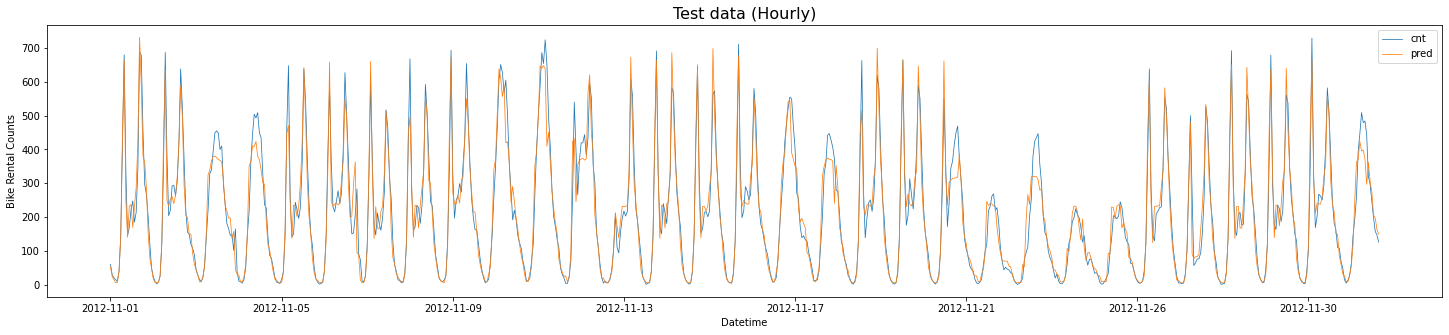

In [14]:
fig, ax = plt.subplots(figsize=(25, 5))
testing["cnt"].plot(linewidth=0.75, ax=ax)
testing["pred"].plot(linewidth=0.75, ax=ax)
ax.set_ylabel("Bike Rental Counts")
ax.set_xlabel("Datetime")
ax.set_title("Test data (Hourly)", fontsize=16)
ax.legend(loc='best')
fig.savefig(f"regression/Test Data (Hourly).png")

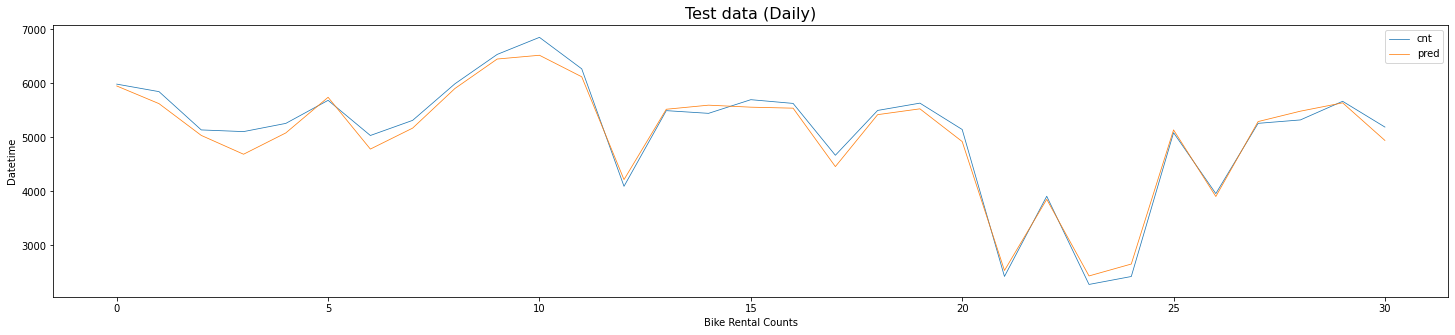

In [15]:
fig, ax = plt.subplots(figsize=(25, 5))
test_tmp["cnt"].plot(linewidth=0.75, ax=ax)
test_tmp["pred"].plot(linewidth=0.75, ax=ax)
ax.set_xlabel("Bike Rental Counts")
ax.set_ylabel("Datetime")
ax.set_title("Test data (Daily)", fontsize=16)
ax.legend(loc='best')
fig.savefig(f"regression/Test Data (Daily).png")

In [146]:
import pickle
filename = 'model.sav'
pickle.dump(model, open(filename, 'wb'))

In [147]:
# load the model from disk
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(X_test, y_test)
print(result)

0.9299775742192237


In [148]:
result = loaded_model.score(X_validation, y_validation)
print(result)

0.9425828404720789
